<a href="https://colab.research.google.com/github/lingliao/Machine-learning-model/blob/main/clothes_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy==1.9.0

In [ ]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
! gdown --id 1UBP6-XQwt0qzgZpRsDaN2NFeBhJ4Mwdz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1UBP6-XQwt0qzgZpRsDaN2NFeBhJ4Mwdz
To: /content/sample_submission_I5njJSF.csv
100% 90.0k/90.0k [00:00<00:00, 89.2MB/s]


In [ ]:
! gdown --id 19x_QuN6W0Rn1cAxJdH5HASFRA7y9tSHG

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19x_QuN6W0Rn1cAxJdH5HASFRA7y9tSHG
To: /content/test_ScVgIM0.zip
100% 13.8M/13.8M [00:00<00:00, 28.0MB/s]


In [ ]:
! gdown --id 18lPt1djLLEd62wm8ANZ2AGQN4AHq8-p5

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18lPt1djLLEd62wm8ANZ2AGQN4AHq8-p5
To: /content/train_LbELtWX.zip
100% 82.5M/82.5M [00:01<00:00, 44.6MB/s]


In [ ]:
!unzip test_ScVgIM0.zip

In [ ]:
!unzip train_LbELtWX.zip

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

sample_submission = pd.read_csv('drive/MyDrive/data_deeplearning/sample_submission_I5njJSF.csv')

train.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [ ]:
# loading training images
train_img = []
for img_name in tqdm(train['id']):
    # defining the image path
    image_path = 'train/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_y = train['label'].values
train_x.shape

100%|██████████| 60000/60000 [00:52<00:00, 1140.53it/s]


(60000, 28, 28)

In [ ]:
# loading test images
test_img = []
for img_name in tqdm(test['id']):
    # defining the image path
    image_path = 'test/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)

# converting the list to numpy array
test_x = np.array(test_img)
test_x.shape

100%|██████████| 10000/10000 [00:07<00:00, 1365.08it/s]


(10000, 28, 28)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4c6d76d810>,
 <matplotlib.image.AxesImage at 0x7f4c6d6aa410>)

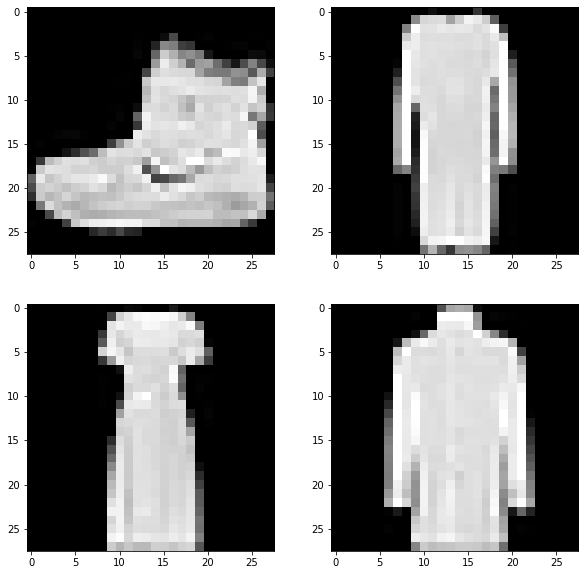

In [ ]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

In [ ]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((54000, 28, 28), (54000,)), ((6000, 28, 28), (6000,)))

In [ ]:
# converting training images into torch format
train_x = train_x.reshape(54000, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([54000, 1, 28, 28]), torch.Size([54000]))

In [ ]:
# converting validation images into torch format
val_x = val_x.reshape(6000, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([6000, 1, 28, 28]), torch.Size([6000]))

In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            #torch.nn.Dropout(p=.2),
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [ ]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [ ]:
# defining the number of epochs
n_epochs = 40
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

RuntimeError: ignored

In [ ]:

# prediction for training set
with torch.no_grad():
    output = model(train_x.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

0.7646481481481482

In [ ]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

0.7698333333333334

In [ ]:
test=[]
for i in range(len(train_losses)):
  test_=train_losses[i].data
  test.append(test_)
val=[]
for i in range(len(val_losses)):
  val_=val_losses[i].data
  val.append(val_)
print(val)

data_test=[]
for i in range(len(test)):
  data_test_=test[i].to("cpu").numpy()
  data_test.append(data_test_)

data_val=[]
for i in range(len(val)):
  data_val_=val[i].to("cpu").numpy()
  data_val.append(data_val_)
print(data_val)

[tensor(2.6935, device='cuda:0'), tensor(5.8804, device='cuda:0'), tensor(3.8515, device='cuda:0'), tensor(3.1729, device='cuda:0'), tensor(2.4206, device='cuda:0'), tensor(1.9770, device='cuda:0'), tensor(1.6989, device='cuda:0'), tensor(1.4159, device='cuda:0'), tensor(1.2440, device='cuda:0'), tensor(1.1813, device='cuda:0'), tensor(1.1697, device='cuda:0'), tensor(1.1571, device='cuda:0'), tensor(1.1320, device='cuda:0'), tensor(1.1072, device='cuda:0'), tensor(1.0864, device='cuda:0'), tensor(1.0585, device='cuda:0'), tensor(1.0136, device='cuda:0'), tensor(0.9530, device='cuda:0'), tensor(0.9120, device='cuda:0'), tensor(0.8916, device='cuda:0'), tensor(0.8684, device='cuda:0'), tensor(0.8455, device='cuda:0'), tensor(0.8390, device='cuda:0'), tensor(0.8334, device='cuda:0'), tensor(0.8111, device='cuda:0'), tensor(0.7877, device='cuda:0'), tensor(0.7783, device='cuda:0'), tensor(0.7682, device='cuda:0'), tensor(0.7532, device='cuda:0'), tensor(0.7458, device='cuda:0'), tensor(0.

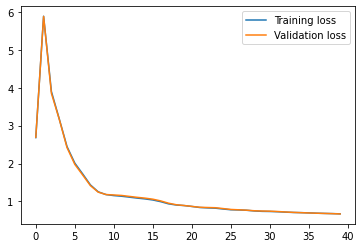

In [ ]:
plt.plot(data_test, label='Training loss')
plt.plot(data_val, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
# converting training images into torch format
test_x = test_x.reshape(10000, 1, 28, 28)
test_x  = torch.from_numpy(test_x)
test_x.shape

torch.Size([10000, 1, 28, 28])

In [ ]:
with torch.no_grad():
    output = model(test_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

In [ ]:
sample_submission['label'] = predictions
sample_submission.head()

,id,label
0,60001,7
1,60002,2
2,60003,1
3,60004,1
4,60005,6


In [ ]:

# saving the file
sample_submission.to_csv('submission.csv', index=False)